# Compare to Single Velocity Model
Assess how well our model trained on separate velocities compares to our previous models trained on only a single velocity

In [1]:
%matplotlib inline
import sys
import os

# Add the directory containing your module to the Python path
sys.path.append(os.path.abspath('/scratch/users/elzhou2/stopping-power-ml'))

from matplotlib import pyplot as plt
from stopping_power_ml.integrator import TrajectoryIntegrator
from sklearn.metrics import mean_absolute_error
from scipy.stats import spearmanr
import pickle as pkl
import pandas as pd
import numpy as np
import keras
import os

2024-06-25 16:13:17.295861: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-25 16:13:17.296642: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-25 16:13:18.393987: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-25 16:13:19.294658: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2024-06-25 16:13:46.779611: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Load in the Model and Featurizer
The model is saved in Keras h5, and the featurizer is in the root directory

In [2]:
model = keras.models.load_model('model.h5')

In [3]:
with open('featurizer.pkl', 'rb') as fp:
    featurizers = pkl.load(fp)

In [4]:
start_frame = pkl.load(open(os.path.join('..', 'al_starting_frame.pkl'), 'rb'))

In [5]:
train_data = pd.concat([
    pd.read_pickle(os.path.join('/scratch/users/elzhou2/stopping-power-ml/multiple-velocities', 'random_traj.pkl')),
    pd.read_pickle(os.path.join('/scratch/users/elzhou2/stopping-power-ml/multiple-velocities', 'channel_traj.pkl'))
], sort=False)

In [6]:
# with open(os.path.join('..', 'single-velocity', 'traj_computer.pkl'), 'rb') as fp:
#     traj_int_single = pkl.load(fp)

In [7]:
data = pd.read_pickle(os.path.join('..', 'training_data.pkl.gz'))

## Retrain on Both Channel and Random
This will give us a direct comparison to the single velocity model. The weights will start from the weights learned from the random trajectory.

In [8]:
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

In [9]:
callbacks = [keras.callbacks.EarlyStopping(monitor='mean_absolute_error', patience=100, verbose=0, mode='auto'),
             keras.callbacks.ReduceLROnPlateau('mean_absolute_error', min_delta=1e-6)]

In [10]:
%%time
history = model.fit(train_data[featurizers.feature_labels()], train_data['force'], callbacks=callbacks, verbose=0, epochs=1000)

CPU times: user 14min 23s, sys: 21.1 s, total: 14min 44s
Wall time: 21min 17s


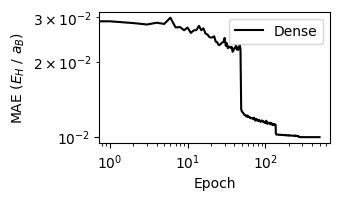

In [11]:
fig, ax = plt.subplots()

ax.loglog(history.epoch, history.history['mean_absolute_error'], 'k', label='Dense')

ax.set_ylabel('MAE ($E_H$ / $a_B$)')
ax.set_xlabel('Epoch')

ax.legend()

fig.set_size_inches(3.5, 2.1)
fig.tight_layout()

*Finding*: It does converge in a few hundred epochs

Save for later use

In [12]:
model.save('model-random-and-channel.h5')

## Get Trajectory Integration Tools
These black box the annoying parts of making the trajectories. We'll re-use the one for single velocities (imported earlier)

In [13]:
traj_int = TrajectoryIntegrator(start_frame, model, featurizers)

## Plot the Performance on $v=1.0$ Trajectories
This is the trajectories for which we have the most data

In [14]:
v1_data = data[np.isclose(data['velocity_mag'], 1.0, atol=1e-3)]

  1/294 ━━━━━━━━━━━━━━━━━━━━ 41s 141ms/step

 64/294 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step 

129/294 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step

195/294 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step

261/294 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step

294/294 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step

294/294 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step


  1/294 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step

 66/294 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step

134/294 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step

201/294 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step

266/294 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step

294/294 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step


  1/294 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step

 70/294 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step

140/294 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step

210/294 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step

280/294 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step

294/294 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step


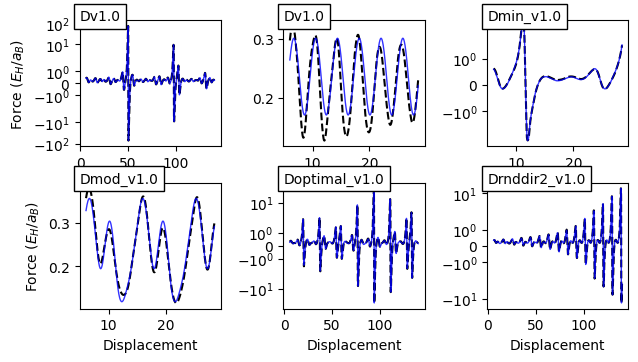

In [15]:
fig, axs = plt.subplots(2, 3)
axs = axs.flatten()

acc_scores = []

for i, (ax, (d, subset)) in enumerate(zip(axs, v1_data.groupby('directory'))):
    subset = subset.query('displacement > 6')
    
    # Get the values
    # single_pred = traj_int_single.model.predict(subset[traj_int_single.featurizers.feature_labels()])
    multi_pred = traj_int.model.predict(subset[traj_int.featurizers.feature_labels()])
    
    # Plot them
    ax.plot(subset['displacement'], subset['force'], 'k--')
    # ax.plot(subset['displacement'], single_pred, 'r', lw=1, alpha=0.8)
    ax.plot(subset['displacement'], multi_pred, 'b', lw=1, alpha=0.8)
    
    if subset['force'].max() > 1:
        ax.set_yscale('symlog')
    
    # Make a label for the figure
    ax.text(0, 1, os.path.basename(d), bbox={'facecolor': 'w', 'edgecolor': 'k'},
           transform=ax.transAxes)
    
    # Make axes labels
    if i >= 3:
        ax.set_xlabel('Displacement')
    if i % 3 == 0:
        ax.set_ylabel('Force ($E_H / a_B$)')
        
    # Measure the accuracy
    acc_scores.append({
        'subset': d,
        # 'mae_single': mean_absolute_error(subset['force'], single_pred),
        'mae_multi': mean_absolute_error(subset['force'], multi_pred),
        # 'spearman_single': spearmanr(subset['force'], single_pred)[0],
        'spearman_multi': spearmanr(subset['force'], multi_pred)[0],
        'stopping': subset['force'].mean(),
        # 'stopping_single': single_pred.mean(),
        'stopping_multi': multi_pred.mean(),
    })
        
            
fig.tight_layout()
fig.set_size_inches(6.5, 3.5)
fig.savefig(os.path.join('figures', 'validation-set.png'), dpi=320)

*Finding*: They look pretty similar

### Compare the Scores Quantitatively
See if the models just "appear better"

In [16]:
acc_scores = pd.DataFrame(acc_scores)

In [17]:
acc_scores

,subset,mae_multi,spearman_multi,stopping,stopping_multi
0,datasets/256_Al/Dv1.0,0.008698,0.996122,0.240193,0.238550
1,datasets/Al_256_channel/Dv1.0,0.022625,0.900558,0.221916,0.236873
2,datasets/Dmin_v1.0,0.020669,0.998605,0.270083,0.263086
3,datasets/Dmod_v1.0,0.009353,0.989121,0.241831,0.242450
4,datasets/Doptimal_v1.0,0.018673,0.997225,0.240920,0.240290
5,datasets/Drnddir2_v1.0,0.013438,0.995520,0.248845,0.249427


#### Compare Fitness to Forces
This is one metric of success

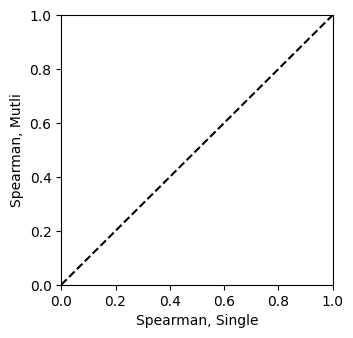

In [18]:
fig, ax = plt.subplots()

# ax.scatter(acc_scores['spearman_single'], acc_scores['spearman_multi'])

ax.set_xlim(ax.get_xlim())
ax.set_ylim(ax.get_xlim())

ax.plot(ax.get_xlim(), ax.get_ylim(), 'k--')

ax.set_xlabel('Spearman, Single')
ax.set_ylabel('Spearman, Mutli')

fig.set_size_inches(3.5, 3.5)

*Finding*: The Spearman correlation coefficient for the multi-velocity model is generally better.

### Compare Stopping Powers
Which gives a better stopping power prediction

In [19]:
print('Multi-Velocity MAE: {:.3e} E_H/a_B'.format(mean_absolute_error(acc_scores['stopping'], acc_scores['stopping_multi'])))
print('Multi-Velocity MAE: {:.2f}%'.format(100 * np.mean(np.abs(acc_scores['stopping'] - acc_scores['stopping_multi']) / acc_scores['stopping'])))

Multi-Velocity MAE: 4.238e-03 E_H/a_B
Multi-Velocity MAE: 1.79%


In [20]:
# print('Single-Velocity MAE: {:.3e} E_H/a_B'.format(mean_absolute_error(acc_scores['stopping'], acc_scores['stopping_single'])))
# print('Single-Velocity MAE: {:.2f}%'.format(100 * np.mean(np.abs(acc_scores['stopping'] - acc_scores['stopping_single']) / acc_scores['stopping'])))

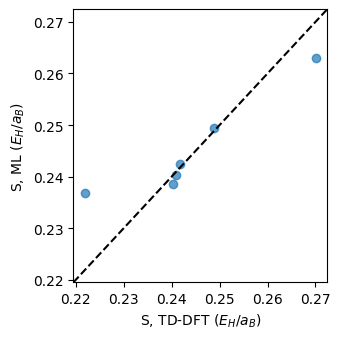

In [21]:
fig, ax = plt.subplots()

ax.scatter(acc_scores['stopping'], acc_scores['stopping_multi'], label='Multi', alpha=0.7)
# ax.scatter(acc_scores['stopping'], acc_scores['stopping_single'], label='Single', alpha=0.7)

ax.set_ylim(ax.get_xlim())
ax.set_xlim(ax.get_ylim())

ax.plot(ax.get_xlim(), ax.get_ylim(), 'k--')

ax.set_xlabel('S, TD-DFT ($E_H/a_B$)')
ax.set_ylabel('S, ML ($E_H/a_B$)')

fig.set_size_inches(3.5, 3.5)
fig.tight_layout()

*Finding*: The multi-velocity model has *slightly* better stopping power predictions.